In [1]:
import matplotlib.pyplot as plt
from reproject import reproject_interp

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

import sunpy.map
from sunpy.coordinates import Helioprojective, RotatedSunFrame, transform_with_sun_center
from sunpy.net import Fido, attrs as a

import datetime

import aiapy
from aiapy.calibrate import register, update_pointing, normalize_exposure

import warnings
warnings.filterwarnings("ignore")

print(sunpy.__version__)
print(aiapy.__version__)


3.0.1
0.6.0


In [2]:
current_date = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S")

past = datetime.datetime.now()-datetime.timedelta(minutes=2)

past_date = past.strftime("%Y-%m-%dT%H:%M:%S")

print(past_date)
print(current_date)

startt = str(past_date)
endt= str(current_date)

result = Fido.search(a.Time(startt, endt),
                     a.Instrument("aia"), a.Wavelength(94*u.angstrom) )
print(result)

2021-11-02T11:40:56
2021-11-02T11:42:56
Results from 1 Provider:

1 Results from the VSOClient:
       Start Time               End Time        Source Instrument ... Wavetype Extent Type   Size              Info            
                                                                  ...                       Mibyte                             
----------------------- ----------------------- ------ ---------- ... -------- ----------- ------- ----------------------------
2021-11-02 11:42:00.000 2021-11-02 11:42:00.000    SDO        AIA ...   NARROW    FULLDISK 4.01562 AIA level 1.5 NRT, 1024x1024




Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

aia20211102_114200_0094.fits:   0%|          | 0.00/4.21M [00:00<?, ?B/s]

2021-11-02T11:41:59.122


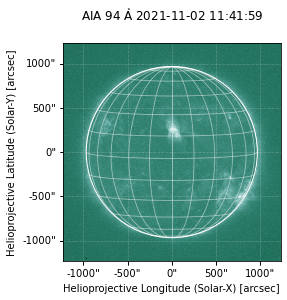

In [3]:
file_download = Fido.fetch(result[0, 0], site='ROB')
aiamap = sunpy.map.Map(file_download[0])
print(aiamap.date)

fig = plt.figure()
ax = fig.add_subplot(111, projection=aiamap)
aiamap.plot()
aiamap.draw_limb()
aiamap.draw_grid()

plt.show()

In [13]:
def draw_nustar_fov(center_x, center_y, layers=[-100, 0, 100], colors='red'):
    """
    Draw squares representing NuSTAR's field of view on the current map.
    
    By default, three squares are drawn: one that is equal
    to the 12x12 arcminute FOV and two with side lengths
    of +-100 arcseconds from the actual side lengths.
    
    Parameters
    ----------
    center_x : float
        The x position, in arcseconds, of the squares' center point.
    center_y : float
        The y position, in arcseconds, of the squares' center point.
    layers : list
        List of values, in arcseconds, containing the adjustments
        to the side lengths of the drawn squares. Each value results
        in a new square drawn on the map.
    colors : str or list of str
        The colors of the drawn squares. If colors is a string,
        then each square will be drawn with that color.
        Otherwise, a list can be provided to customize the color
        of each layer. The index of the color will match the index
        of the layer.
    """
    
    # Change the colors variable to a list if it's not already one.
    if not isinstance(colors, list):
        colors = [colors]*len(layers)
    
    FOV_SIDE_LENGTH = 12*60 # Units of arcseconds

    for i, diff in enumerate(layers):
        # Translate to bottom left corner of rectangle
        bottom_left = ((center_x - FOV_SIDE_LENGTH/2 - diff)*u.arcsec,
                       (center_y - FOV_SIDE_LENGTH/2 - diff)*u.arcsec)
        rect_bl = SkyCoord(*bottom_left, frame=out_warp.coordinate_frame)

        out_warp.draw_quadrangle(bottom_left=rect_bl,
                                 width=(FOV_SIDE_LENGTH+2*diff)*u.arcsec,
                                 height=(FOV_SIDE_LENGTH+2*diff)*u.arcsec,
                                 color=colors[i])

<RotatedSunHelioprojective Frame (base=<Helioprojective Frame (obstime=2021-11-21T12:00:00.000, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate for 'earth'>)>, duration=-19.01251016203704 d, rotation_model=howard)>


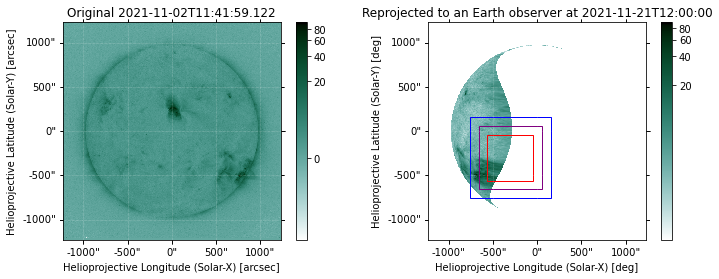

In [16]:
in_time = aiamap.date
out_time = '2021-11-21T12:00:00'
out_frame = Helioprojective(observer='earth', obstime=out_time, rsun=aiamap.coordinate_frame.rsun)
rot_frame = RotatedSunFrame(base=out_frame, rotated_time=in_time)
print(rot_frame)

out_shape = aiamap.data.shape
out_center = SkyCoord(0*u.arcsec, 0*u.arcsec, frame=out_frame)
header = sunpy.map.make_fitswcs_header(out_shape,
                                       out_center,
                                       scale=u.Quantity(aiamap.scale))
out_wcs = WCS(header)
out_wcs.coordinate_frame = rot_frame

with transform_with_sun_center():
    arr, _ = reproject_interp(aiamap, out_wcs, out_shape)
    
out_warp = sunpy.map.Map(arr, out_wcs)
out_warp.plot_settings = aiamap.plot_settings

reversed_cmap = (aiamap.cmap).reversed()

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(1, 2, 1, projection=aiamap)
aiamap.plot(cmap=reversed_cmap, title=f'Original {in_time}')
plt.colorbar()

ax2 = fig.add_subplot(1, 2, 2, projection=out_warp)
out_warp.plot(cmap=reversed_cmap, title=f"Reprojected to an Earth observer at {out_time}")
plt.colorbar()

# Set coordinates for NuSTAR FOV.
center_x = -300
center_y = -300
layers = [100, 0, -100]

draw_nustar_fov(center_x, center_y, layers)

plt.show()